citations:
emojifier deep learning.ai

In [1]:
import pandas as pd
import math
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [3]:
dfData = pd.read_csv('/home/archit/Desktop/ad vs organic/final_combined_lang_organic_duration2.csv').drop('Unnamed: 0', axis =1)
dfData.columns

Index(['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories', 'Lang'],
      dtype='object')

In [4]:
dfData.shape

(120876, 35)

In [5]:
dfData[dfData['Lang'] == 'en'].shape[0]

62335

In [4]:
dfData.groupby('Lang').count()

,vid,channelId,duration,licensedContent,definition,dislikeCount,commentCount,favoriteCount,viewCount,likeCount,...,Channel subscriberCount,Channel commentCount,Channel videoCount,Channel showRelatedChannels,Channel featuredChannelsUrls,Channel noOfFeaturedChannels,Channel country,Channel keywords,Channel topicIds,Channel topicCategories
Lang,,,,,,,,,,,,,,,,,,,,,
af,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
ca,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
cy,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
da,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
de,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
en,62335,62335,62335,62335,62335,62335,62335,62335,62335,62335,...,62335,62335,62335,62335,62335,62335,62335,62335,62335,62335
es,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
et,219,219,219,219,219,219,219,219,219,219,...,219,219,219,219,219,219,219,219,219,219
fi,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


Next we will set up our input dataset and define the function for model training

In [5]:
def input_dataset(dfData, views =0, categories =[], country= ['IN']):
    """manipulates input dataframe according to input parameters.
    Args:
        dfData: input dataset
        views: minimum number of views in dfData.Default = 0.
        categories: list of categories to be present in final dataset.Default is empty list(all categories)
        country: List of countries whose videos should be present in dataSet. Default is India.
    Returns:
        dataset to train model on
    """
    # slice dataset with viewCount larger than views
    dfData = dfData[dfData['viewCount'] >= views]
    # concat dfData according to categories
    categoryIds =(dfData['categoryId'].dropna().unique()).tolist()
    # create temporary df
    tempDf = pd.DataFrame(columns = ['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'])
    for categoryId in categoryIds:
        df = dfData[dfData['categoryId'] == categoryId]
        keys = []
        keys[0], keys[1] = tempDf['categoryId'][0], df['categoryId'][0]
        tempf = pd.concat([tempDf, df], ignore_index = True, keys = keys)
        
    # select dataframe according to categories
    if len(categories) != 0:
        dfData = tempDf.loc[categories]
    else:
        dfData = tempDf
    
    # choosing countries
    if len(country) != 0:
            dfData = dfData.loc[dfData['Channel country'] == country, ]
    else:
        dfData = dfData.loc[dfData['Channel country'] == 'IN']
        
    return dfData

In [28]:
def preprocessing(dfData):
    """drops irrelevant features, merges adStats and previous video stats
    Args:
    dfData: input DataSet
    Return:
    merged DataSet
    """
    # drop irrelevant features
    dfData = dfData.drop(['licensedContent', 'relevantTopicIds', 'topicIds', 'topicCategories', 'channelTitle', 'Channel Title', 'Channel Description', ' Channel hiddenSubscriberCount', 'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'], axis = 1)
    
    # load advertisement and previous stats dataset and clean
    dfAdStats = pd.read_csv('/home/archit/Desktop/ad vs organic/resultstats.csv').drop(['ch_id','Unnamed: 0'], axis =1)
    dfAdStats.rename(columns = {'video_id':'vid'}, inplace = True)
    dfPrevStats = pd.read_csv('/home/archit/Desktop/ad vs organic/previousVideoStats2.csv').drop(['Unnamed: 0'], axis =1)
    dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

    # merge DataSet
    dfMergedData = dfData.merge(dfPrevStats, on = 'vid', how = 'left')
    dfMergedData = dfMergedData.merge(dfAdStats, on = 'vid', how = 'left')
    return dfMergedData

In [50]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    dfData['is_english'] = dfData['Lang'].apply(lambda x: 1 if x=='en' else 0)
    dfData = dfData.drop('Lang', axis=1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData['Definition'] = dfData['definition'].apply(lambda x: 1 if x=='hd' else 0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [51]:
#dfData = preprocessing(dfData)
dfData.head()

,vid,channelId,duration,definition,dislikeCount,commentCount,favoriteCount,viewCount,likeCount,title,...,Channel commentCount,Channel videoCount,Lang,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,ad%
0,mqZsF63zEN4,UC-4k5iBbLA1Q1qELNvjagCA,1375.0,hd,5.0,20.0,0.0,286118.0,1256.0,Nhỏ To Cùng Mẹ | Phụ Nữ Xăm Mình Là Thần Thái ...,...,0.0,118.0,NaN,20.0,5.0,1256.0,2018-01-16T03:30:00.000Z,286118.0,Nhỏ To Cùng Mẹ | Phụ Nữ Xăm Mình Là Thần Thái ...,28.055425
1,S9UM-hOBGiA,UC-4k5iBbLA1Q1qELNvjagCA,126.0,hd,3.0,0.0,0.0,262925.0,10.0,"[Tã Quần BINO] MV Ngủ Ngoan, Đã Có BINO!",...,0.0,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.889202
2,E2XB_V-6dwU,UC-4k5iBbLA1Q1qELNvjagCA,1482.0,hd,6.0,31.0,0.0,309189.0,1104.0,"Nhỏ To Cùng Mẹ | Trang Hạ & Phương Trinh nói ""...",...,0.0,118.0,NaN,31.0,6.0,1104.0,2018-01-31T09:00:03.000Z,309189.0,"Nhỏ To Cùng Mẹ | Trang Hạ & Phương Trinh nói ""...",52.534355
3,3lDqDhyKBwg,UC-4k5iBbLA1Q1qELNvjagCA,607.0,hd,17.0,21.0,0.0,41380.0,130.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 21 - Bù...,...,0.0,118.0,NaN,21.0,17.0,130.0,2016-11-15T07:11:54.000Z,41380.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 21 - Bù...,0.000000
4,qPkIkKC-Kvw,UC-4k5iBbLA1Q1qELNvjagCA,552.0,hd,13.0,18.0,0.0,60971.0,129.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 31 - Nh...,...,0.0,118.0,NaN,18.0,13.0,129.0,2016-11-15T07:14:34.000Z,60971.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 31 - Nh...,0.000000


In [40]:
#dfData.drop(['level_0', 'Unnamed: 0', 'index'], axis=1, inplace=True)
dfData.columns

Index(['vid', 'channelId', 'duration', 'definition', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'Lang',
       'PrevCommentCount', 'PrevDislikeCount', 'PrevLikeCount',
       'PrevPublishedAt', 'PrevViewCount', 'PrevTitle', 'ad%'],
      dtype='object')

In [52]:
dfTrainingSet = dfData.loc[dfData['ad%'] == 0,]
dfTrainingSet.shape

(112873, 27)

In [57]:
df = feature_engineer(dfTrainingSet)
df = df[df['is_english'] == 1]

In [62]:
X, y = df.drop('viewCount',axis = 1) , df['viewCount']
X.shape

(56671, 18)

In [63]:
y = np.log(y)

In [10]:
def train_model(model):
    """Trains the dataSet using Gradient Boosted Regressor
    Args:
    input_features: input feature set
    model: an int. 1 to predict organic views, 2 to predict advertisement views
    Returns:
    A Pandas "Dataframe' containing targets and corresponding prediction after training the model.
    """
    

runnning stuff of LSTM

In [6]:
# select dfData with english language
dfData = dfData[dfData['Lang'] == 'en'].reset_index()
dfData['textData'] = dfData['description']+dfData['title']+dfData['tags']

In [20]:
dfData.columns

Index(['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories', 'Lang',
       'cleanDescriptions'],
      dtype='object')

In [19]:
dfData.drop(['level_0', 'index', 'textData'], axis=1, inplace=True)

In [21]:
dfData.to_csv('/home/archit/Desktop/ad vs organic/final_combined_lang_organic_duration3.csv')

In [10]:
# preprocess descriptions for glove embedding
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


dfData['cleanDescriptions']=dfData['textData'].map(lambda s:preprocess(s)) 

In [59]:
#descriptions = dfData['cleanDescriptions']
print(len(descriptions))
maxLen = len(max(descriptions, key=len).split())
maxLen

62335


632

dfData.to_csv('/home/archit/Desktop/ad vs organic/final_combined_lang_organic_duration3.csv')

In [ ]:
# preprocess descriptions for glove embedding

# clean puncts from description of reach video in dataset
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

# remove numbers
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

# remove hyperlinks
def clean_links(x):
    x = re.sub(r"http\S+", '', x)
    return x

# remove special characters
def clean_spl_char(x):
    x = re.sub(r'\s+', '', x)
    return x

In [12]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/home/archit/Desktop/ad vs organic/glove.6B.50d.txt')

In [13]:
word = "the"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of the in the vocabulary is 357266
the 289846th word in the vocabulary is potatos


In [16]:
# take glove embedding of each word and averages over sentence
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Split sentence into list of lower case words (≈ 1 line)
    words = [i.lower() for i in sentence.split()]

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((50,))
    
    # average the word vectors. You can loop over the words in the list "words".
    for w in words:
            avg += word_to_vec_map[w]
    avg = avg / len(words)
    
    
    return avg

In [21]:
# apply sentence_to_avg to each description of videos
# create a feature dfData['embedding'] and feed to regression model
embedding = []
count = 0
Ids = []
for description in descriptions:
    try:
        embedding.append(list(sentence_to_avg(description, word_to_vec_map)))
    except KeyError as e:
        print(e)
        pass
print(len(embedding))


'darshanraval'
'chehak'
'pukarta'
'bharreya'
'lataji'
'acousticrishabh'
'showkidd'
'swarankan'
'harshit'
'jasleen'
'sourabh'
'nibhana'
'acousticrishabh'
'harshit'
'awarapan'
'chankitthan'
'kunwara'
'shemaroo'
'dulhe'
'shemaroo'
'shemaroo'
'swarag'
'shemaroo'
'shemaroo'
'riteish'
'shemaroo'
'shemaroo'
'shemaroo'
'dulhe'
'aishwariya'
'riteish'
'zulmi'
'shemaroo'
'funshh'
'bhagam'
'shemaroo'
'shemaroo'
'shemaroo'
'jaaneman'
'shemaroo'
'shemaroo'
'shemaroo'
'dulhe'
'bheja'
'hillarious'
'kudalkar'
'dulhe'
'shemaroo'
'fortune_teller'
'rajyog'
'shivnath'
'shemaroo'
'shemaroo'
'jaroori'
'parmeet'
'shemaroo'
'incidently'
'sukhani'
'shemaroo'
'saawan'
'hillarious'
'shemaroo'
'shemaroo'
'chhalia'
'shemaroo'
'shemaroo'
'shemaroo'
'shemaroo'
'shemaroo'
'starcast'
'shemaroo'
'mistakens'
'shemaroo'
'dulhe'
'shemaroo'
'shemaroo'
'yaaro'
'shemaroo'
'shemaroo'
'shemaroo'
'shemaroo'
'dulhe'
'shemaroo'
'malamal'
'gholat'
'shemaroo'
'shemaroo'
'dhondu'
'shemaroo'
'shemaroo'
'shemaroo'
'shivnath'
'shemaroo'

'bhaktisongs'
'mahimala'
'bhaktisongs'
'kanakadhara'
'prardhana'
'bhaktisongs'
'devitional'
'jaibhavani'
'saranamadainthen'
'nadha'
'bhaktisongs'
'nrusimha'
'mallanna'
'geethalu'
'kondagattu'
'yerra'
'poriro'
'bhaktisongs'
'jangamayya'
'bhaktisongs'
'medaram'
'eduta'
'yeasuvin'
'kodavela'
'hrudayam'
'yesu'
'sandesam'
'bhaktisongs'
'swarupa'
'mittapalli'
'bhaktisongs'
'sabarigirisha'
'sammakka'
'pothuloori'
'kalahsteswara'
'viplava'
'puthrudu'
'sthothram'
'devitional'
'bakthi'
'preminchina'
'karampidithu'
'elunthuvaa'
'geethalu'
'mavurala'
'eswarudu'
'kaluvari'
'devitional'
'evvaro'
'pothunna'
'nrusimha'
'bhaktisongs'
'palana'
'mysigandi'
'mhankalamma'
'mallanna'
'puthumai'
'geethalu'
'geethalu'
'kanipaka'
'devitional'
'yeasu'
'devitional'
'tolliyunu'
'relarelarelaa'
'bhaktisongs'
'putraya'
'yeasu'
'bhaktisongs'
'bhaktisongs'
'devitional'
'eswara'
'devitional'
'devitional'
'sandhana'
'bhaktisongs'
'theivangal'
'bhaktisongs'
'saranam'
'kondagattu'
'viplava'
'aakasama'
'ayinavolu'
'nede'


'devitional'
'mallanna'
'parisudda'
'yentha'
'devitional'
'ninnu'
'geethalu'
'bhaktisongs'
'saranam'
'sthuthi'
'magathuva'
'nuthanavarsham'
'eswara'
'bhaktisongs'
'bhaktisongs'
'ethade'
'kanakadhara'
'bhaktisongs'
'jivulagala'
'devitional'
'vaibhavam'
'bathukamma'
'bhaktisongs'
'bhaktisongs'
'devitional'
'seetharama'
'suprabatham'
'eswara'
'srimandatha'
'ededu'
'devitional'
'kanakadhara'
'devitional'
'bhaktisongs'
'jeevam'
'manasasmarami'
'eswara'
'gyathri'
'devitional'
'namobhuthanadha'
'smarami'
'vurugathao'
'devitional'
'aggidevudu'
'thayanavan'
'thandri'
'eswarudu'
'bhaktisongs'
'pancharatnam'
'thedum'
'eswara'
'kondagattu'
'bhaktisongs'
'shiridi'
'vennelamma'
'pushpanjali'
'enthan'
'yesu'
'swarupa'
'kanarade'
'maradala'
'oggu'
'devitional'
'geethalu'
'eswara'
'sankeerthana'
'pancharatnam'
'eswara'
'bhaktisongs'
'viplava'
'nimmathi'
'bhaktisongs'
'bhaktisongs'
'bhaktisongs'
'viplava'
'bakthi'
'bhaktisongs'
'geethalu'
'bhaktisongs'
'bhaktisongs'
'bhaktisongs'
'jathara'
'prardhana'
'

'ayagiri'
'sarveshwara'
'bakthi'
'thenela'
'pothunna'
'bhaktisongs'
'kalvari'
'puhalanjali'
'adivo'
'shiridi'
'vinnapaalu'
'athmudaiyundi'
'viplava'
'bhaktisongs'
'sannidhanam'
'devitional'
'devitional'
'charithra'
'devitional'
'kattedura'
'viplava'
'bhaktisongs'
'shiridi'
'prardhana'
'bhaktisongs'
'jallu'
'bhaktisongs'
'bhavanalo'
'namalu'
'sthothramaala'
'viplava'
'manasmarami'
'veerudu'
'chudu'
'aatalevi'
'vigneswara'
'bhaktisongs'
'lakshimi'
'shiridi'
'joharlu'
'devitional'
'pochamma'
'andhala'
'devitional'
'bhaktisongs'
'vigneswara'
'devitional'
'srisaila'
'eswara'
'mesalodu'
'devitional'
'inithana'
'geethalu'
'bhaktisongs'
'devitional'
'arulvaye'
'durgamma'
'mahimai'
'manchi'
'panchakshari'
'anjanna'
'yellammana'
'komaravelli'
'eswara'
'viplava'
'eswara'
'suprabhatham'
'bhaktisongs'
'srirama'
'manikantudu'
'namashivaya'
'maradala'
'kalvari'
'bhaktisongs'
'annaiyin'
'ammala'
'manikanta'
'bhaktisongs'
'janapadalu'
'devitional'
'dhinam'
'sakthiyin'
'shiridi'
'sarvesvara'
'sammakka'


'raot'
'srilatha'
'parineeti'
'khoshala'
'pehlu'
'lehenga'
'jalota'
'ramky'
'lemark'
'ramchandran'
'dhill'
'siddhivinayak'
'vijaypath'
'hrishita'
'chanti'
'rasiya'
'muhurat'
'lfw'
'mujh'
'karwaan'
'tukkaa'
'aarya'
'tezaab'
'lubhaya'
'bemisaal'
'chikna'
'cinecurry'
'anjaane'
'sarpotdar'
'wisens'
'shakun'
'dhadakne'
'ramnarayan'
'prettyeyes'
'ibw'
'dobriyal'
'kameena'
'ayushmann'
'sendhoorapandi'
'jeethuka'
'dcruz'
'shabreej'
'chakravyuh'
'thunty'
'steffanina'
'nawazuddin'
'durgapuja'
'baahubali'
'kasbekar'
'shuddh'
'sharukh'
'annil'
'sarbojanin'
'hoin'
'cinecurry'
'rajev'
'paranthe'
'jalota'
'tarane'
'ghisa'
'nakra'
'prateik'
'adajania'
'cpaa'
'bhaktraj'
'thengdi'
'sarbjit'
'mchi'
'majaa'
'sabke'
'suyyash'
'udith'
'goru'
'suneel'
'ajnabi'
'bijlee'
'aahen'
'cinecurrytweets'
'kalakaar'
'khandal'
'pratyusha'
'lakshyam'
'jahannum'
'prateik'
'baishakhi'
'balidan'
'laagi'
'shadangule'
'exlclusive'
'aahinsa'
'bakshy'
'galliyaan'
'cinecurry'
'chadda'
'vishwajeet'
'tresemme'
'gulaab'
'gajanana'


'tezaab'
'chandraa'
'wtach'
'mithya'
'shernaz'
'machli'
'chintrangada'
'cinecurry'
'bambai'
'aarakshan'
'samrajya'
'divgikar'
'shav'
'bajrangi'
'hrishita'
'jwalamukhi'
'bhagyashree'
'seemaab'
'shahabadi'
'fromgobhir'
'ayushman'
'nayika'
'cinecurry'
'rajnikant'
'nishtha'
'mixradio'
'aandhi'
'lakshyam'
'nidhie'
'aasman'
'cinecurry'
'ajnabi'
'hasmi'
'welcare'
'ghanchakkar'
'jalota'
'gosai'
'toyata'
'makrand'
'devaiah'
'dongre'
'rooh'
'donear'
'imarti'
'ismoke'
'shuddhi'
'khemu'
'prateik'
'chakori'
'sarfarosh'
'hotchandani'
'fromgobhir'
'pratyusha'
'kozhenova'
'nishtha'
'milap'
'ashmit'
'ajoobe'
'tanhayi'
'jalota'
'jaaved'
'soparrkar'
'adajania'
'rakshita'
'savdhaan'
'muhurat'
'juyal'
'charmme'
'gannguli'
'perizaad'
'israni'
'pareeniti'
'vardee'
'aamby'
'apnon'
'rautela'
'jalota'
'sumona'
'thalaivaa'
'jaaved'
'nawazuddin'
'bakrapur'
'penoza'
'parvarish'
'deepshika'
'brahmastram'
'rawail'
'babuji'
'jalota'
'gayee'
'pravinkanth'
'cinecurrytweets'
'felicitationbollywood'
'suparn'
'dolyanchya'

'mukarji'
'vidoe'
'parineeti'
'amyra'
'pratyusha'
'iijw'
'dvar'
'tarannum'
'mahurat'
'heyy'
'sambhavana'
'shuddhi'
'zindaggi'
'metrocolor'
'lootera'
'yuvika'
'phulwa'
'splitsvilla'
'parineeti'
'choone'
'kaiyum'
'ilzaam'
'vindoo'
'vetaran'
'unse'
'saiyyan'
'gaurang'
'pendse'
'shazahn'
'prabhune'
'samrajya'
'aandhi'
'iftaar'
'ashmit'
'pagdi'
'bijlee'
'khandaan'
'cinecurrytweets'
'mahanayak'
'ranvijay'
'sarfarosh'
'pareshaan'
'zubaan'
'jaaved'
'cnecurry'
'athiya'
'kaash'
'kkkk'
'tammak'
'harmontown'
'cinecurry'
'daaku'
'chadda'
'bindaas'
'takhtani'
'pilgaonkar'
'celebz'
'zakhmi'
'baware'
'intraction'
'mushkil'
'munisha'
'ajoobe'
'rajnikant'
'farz'
'jinali'
'jayapradha'
'pratiek'
'jackky'
'rakshita'
'nauheed'
'cantonen'
'leadstart'
'dharmatma'
'wdd'
'sivapathigaram'
'dsouza'
'bajrangi'
'dandiya'
'cinecurrytweets'
'varsham'
'tevar'
'gambeeram'
'angaaray'
'elaan'
'sportacular'
'milap'
'inorbit'
'gobhir'
'udagata'
'bharke'
'mutamestri'
'vijaykar'
'bhikari'
'hrishitaa'
'scmm'
'manchala'
'cinec

'minisha'
'tenu'
'nishka'
'felicitates'
'vikaramaditya'
'jalota'
'aarya'
'bemisaal'
'mukabala'
'khalnayakon'
'paritosh'
'manyata'
'inagurates'
'wumei'
'bachcha'
'bheegi'
'tanushree'
'shonali'
'bandook'
'rautela'
'baaghi'
'jaaved'
'meeta'
'shiavn'
'krishika'
'tigmanshu'
'rooh'
'bakrapur'
'makhana'
'riteish'
'ayushmann'
'zakhmi'
'cinecurry'
'hawaizaada'
'hugeo'
'ketnav'
'craftsvilla'
'adhyayan'
'chourasia'
'rangrezz'
'prabhudeva'
'cintaa'
'misthi'
'nawaabs'
'cantonen'
'shazahn'
'chitrangda'
'sampada'
'mimicks'
'tisca'
'alighar'
'dulhin'
'aditiya'
'shamitabh'
'cpaa'
'sheroes'
'jackky'
'cinecurrytweets'
'cinecurry'
'cinecurry'
'aashoo'
'bemisaal'
'kaanchi'
'vardee'
'saugandh'
'khakee'
'arfi'
'pahchaan'
'yaaro'
'nafrat'
'nijam'
'vijaypath'
'pulkit'
'cinecurry'
'maaro'
'haisha'
'nikhla'
'cinecurry'
'cecila'
'ronydutta'
'sargun'
'motisagar'
'mangey'
'vardee'
'baadal'
'cinecurry'
'dvar'
'raageshwari'
'dheva'
'sayali'
'padhao'
'kainaz'
'cinecurrytweets'
'khoobsurat'
'taaqat'
'riteish'
'jadui'
'

'shemaroo'
'meenu'
'chukana'
'shemaroo'
'dattani'
'shemaroo'
'saaki'
'hawaizaada'
'sidhant'
'shemaroo'
'shabaaz'
'shemaroo'
'judwaa'
'shemaroo'
'shemaroo'
'shemaroo'
'dushant'
'rukhsar'
'saawan'
'raaste'
'aneez'
'kalantri'
'bhuria'
'romu'
'keshu'
'shemaroo'
'kishenlal'
'shemaroo'
'shemaroo'
'parikshat'
'shemaroo'
'maklai'
'bapaiah'
'bichhoo'
'shemaroo'
'rukhsar'
'shemaroo'
'shemaroo'
'shemaroo'
'shemaroo'
'melvyna'
'kalantri'
'ankhiyan'
'terrozing'
'shemaroo'
'govitrikar'
'shemaroo'
'shemaroo'
'sudent'
'jaikishen'
'shekharan'
'shemaroo'
'dulaara'
'sultanat'
'dedh'
'shemaroo'
'rukhmani'
'keshu'
'adhir'
'vikramjit'
'sultanat'
'shemaroo'
'vijayeta'
'sadma'
'kappor'
'faisla'
'intezaar'
'kalayanji'
'blovkbuster'
'taurani'
'sachaa'
'shemarooent'
'rajendranath'
'chhalia'
'shemaroo'
'shavasana'
'shemaroo'
'shemaroo'
'banarsilal'
'vijayta'
'intezaar'
'lalan'
'khalujan'
'ishqiya'
'ninad'
'psyciatricist'
'kamlakar'
'shemarooent'
'jamunaprasad'
'ghatothkach'
'befools'
'daasi'
'shemaroo'
'jwaala'
'

'suhaan'
'thhink'
'udhaybhan'
'shemaroo'
'classc'
'xcuse'
'vindu'
'bheja'
'tulsiram'
'eazam'
'jaitly'
'raaste'
'shemaroo'
'karans'
'khubsoorat'
'jhulka'
'shemaroo'
'jyothikas'
'shemaroo'
'shemaroo'
'bancharamer'
'rukhsar'
'juari'
'judwaa'
'shemaroo'
'mking'
'gaurang'
'shemaroo'
'idhar'
'rajeshkhanna'
'deepal'
'shemaroo'
'fitoor'
'shagoon'
'ddlj'
'shemaroo'
'bhaye'
'bheja'
'shemaroo'
'shemaroo'
'shemaroo'
'jaikishen'
'joroo'
'aashirwad'
'shemaroo'
'shemaroo'
'dharamraj'
'kaalia'
'shemaroo'
'shemaroo'
'shakka'
'birje'
'khubsoorat'
'shemarooent'
'vijayeta'
'shemaroo'
'dabhral'
'shemaroo'
'andaaz'
'shyamlal'
'bachhan'
'shemaroo'
'sabkuchwala'
'rukhsar'
'shemaroo'
'haricharan'
'madhvi'
'boroplus'
'romu'
'shemaroo'
'shemaroo'
'shemaroo'
'psyciatricist'
'shemaroo'
'shemaroo'
'shemaroo'
'juari'
'meerabai'
'musthafa'
'rakhee'
'dharamdas'
'shemaroo'
'shemaroo'
'rakhee'
'shemaroo'
'shemaroo'
'vairale'
'bhagyashree'
'ranjeeta'
'redhanded'
'ekwari'
'aamirs'
'karans'
'shemaroo'
'kaysi'
'shemaroo'
'r

'andaaz'
'nafrat'
'shemaroo'
'eeshwar'
'minshere'
'shemaroo'
'hattangadi'
'khalu'
'shemaroo'
'karogi'
'robhit'
'shemaroo'
'shemaroo'
'shemaroo'
'shemaroo'
'kalptaru'
'udita'
'dadus'
'shemaroo'
'bewafaa'
'hariram'
'rukhsar'
'shemaroo'
'shemaroo'
'shemaroo'
'shemaroo'
'riteish'
'shemaroo'
'shemaroo'
'kinare'
'shemaroo'
'karogi'
'sabkuchwala'
'kainaz'
'saaya'
'khoobsurat'
'shemaroo'
'kapoors'
'shemaroo'
'jamuar'
'shemaroo'
'shemaroo'
'shemaroo'
'shemaroo'
'taali'
'shemaroo'
'shemaroo'
'shanno'
'shemaroo'
'shemaroo'
'satyamev'
'shemaroo'
'arthi'
'rakhee'
'shemarooent'
'shemaroo'
'shemarooent'
'shemaroo'
'anjalis'
'radhas'
'bajbai'
'jaikishen'
'kalptaru'
'raageshwari'
'shyamlal'
'jaagte'
'shemaroo'
'bancharamer'
'offerred'
'shemarooent'
'shemaroo'
'eeshwar'
'thehre'
'rakhee'
'dulhe'
'roshini'
'aneez'
'devdutt'
'shemaroo'
'classc'
'nutun'
'shemaroo'
'shemaroo'
'shemaroo'
'shemarooent'
'shagoon'
'shemaroo'
'ofice'
'shemaroo'
'aminabai'
'tulsiram'
'shemaroo'
'shemaroo'
'shemaroo'
'rafoo'
'shau

'jabardasth'
'sirish'
'filmnagar'
'hrudaya'
'dasanna'
'filmnagar'
'filmnagar'
'filmnagar'
'filmnagar'
'bhagamati'
'filmnagar'
'gunturodu'
'nayanthara'
'filmnagar'
'filmnagar'
'filmnagar'
'jabardasth'
'lokam'
'filmnagar'
'filmnagar'
'gurram'
'filmnagar'
'sachiin'
'filmnagar'
'chesi'
'amyra'
'nivetha'
'nrnm'
'gurram'
'filmnagar'
'brahmaji'
'pedarayudu'
'kiraaku'
'settai'
'enti'
'charmi'
'speedunnodu'
'evaritho'
'chamak'
'filmnagar'
'bithiri'
'filmnagar'
'needi'
'rajji'
'bhaagamathie'
'taapsee'
'vamshi'
'uyyalawada'
'harshada'
'filmnagar'
'yeppuduraa'
'attarintiki'
'filmnagar'
'filmnagar'
'shatru'
'sammohanam'
'filmnagar'
'rangasthalam'
'filmnagar'
'filmnagar'
'bangaram'
'filmnagar'
'vellipomaakey'
'filmnagar'
'filmnagar'
'khaidi'
'aravindha'
'filmnagar'
'balakrishnudu'
'filmnagar'
'filmnagar'
'filmnagar'
'filmnagar'
'rakul'
'svsc'
'filmnagar'
'kaaki'
'filmnagar'
'rachcha'
'filmnagar'
'duvvada'
'neevevaro'
'filmnagar'
'filmnagar'
'bezawada'
'abhinetri'
'rajji'
'saptagiri'
'mahanati'
'film

'srimannarayana'
'filmnagar'
'filmnagar'
'vakkantham'
'gunturodu'
'lokam'
'anando'
'filmnagar'
'mahadhan'
'happybirthdayntr'
'subcribe'
'filmnagar'
'sasirekha'
'ninnu'
'sharwanand'
'aravindha'
'filmnagar'
'filmnagar'
'filmnagar'
'avanthika'
'filmnagar'
'naruda'
'rangasthalam'
'dibyendu'
'raashi'
'filmnagar'
'filmnagar'
'khakee'
'filmnagar'
'sathamanam'
'filmnagar'
'telugufilmnagar'
'baahubali'
'bhaagamathie'
'adhugo'
'rajji'
'sharwanand'
'rangasthalam'
'filmnagar'
'filmnagar'
'sasirekha'
'lagadapati'
'filmnagar'
'filmnagar'
'premam'
'filmnagar'
'filmnagar'
'srivalli'
'revanth'
'evandi'
'maayam'
'filmnagar'
'sardaar'
'goutham'
'amrutham'
'sathamanam'
'rathode'
'darshakudu'
'pinisetty'
'venkatesaya'
'charmi'
'filmnagar'
'okkadu'
'khaidi'
'filmnagar'
'rakul'
'filmnagar'
'filmnagar'
'filmnagar'
'jabardasth'
'khaidi'
'rangasthalam'
'rangeli'
'filmnagar'
'filmnagar'
'sindooram'
'vishita'
'parvatheesam'
'talasani'
'savyasachi'
'ghatothkachudu'
'dagabaaz'
'konkana'
'alludula'
'nithiin'
'filmna

'filmnagar'
'posani'
'lacchimdeviki'
'yerneni'
'mohabbath'
'prudhvi'
'filmnagar'
'mahanati'
'jabardasth'
'vallabhaneni'
'gunturodu'
'alludu'
'riteish'
'shoban'
'indrasena'
'filmnagar'
'filmnagar'
'filmnagar'
'nuvve'
'filmnagar'
'jawaan'
'posani'
'bhimaneni'
'rakul'
'syamala'
'filmnagar'
'filmnagar'
'filmnagar'
'filmnagar'
'yettaagayya'
'keerthy'
'abhinetri'
'filmnagar'
'mayadari'
'hebah'
'filmnagar'
'filmnagar'
'karimaee'
'galrani'
'gunturodu'
'filmnagar'
'hebah'
'filmnagar'
'filmnagar'
'filmnagar'
'filmnagar'
'biddalu'
'mallanna'
'filmnagar'
'neevalle'
'nannu'
'gajjala'
'filmnagar'
'homanand'
'bramhanandam'
'filmnagar'
'teugu'
'pothineni'
'seethamma'
'speedunnodu'
'haripriya'
'antariksham'
'filmnagar'
'kaadali'
'filmnagar'
'kosame'
'filmnagar'
'filmnagar'
'kannayya'
'sathamanam'
'havish'
'filmnagar'
'samanthakamani'
'rangeli'
'filmnagar'
'attarintiki'
'kandukuri'
'chesave'
'filmnagar'
'lacchimdeviki'
'sampoornesh'
'boyapati'
'rachayitha'
'loukyam'
'hushaaru'
'chesi'
'sampoornesh'
'rak

'neevevaro'
'gajjala'
'filmnagar'
'thamanna'
'mahanati'
'rakul'
'pelliki'
'goutham'
'jawaan'
'filmnagar'
'filmnagar'
'filmnagar'
'vaitla'
'kaaki'
'aravindha'
'jawaan'
'filmnagar'
'dialoges'
'unschool'
'boyapati'
'filmnagar'
'balakirshna'
'thammudu'
'parineeti'
'filmnagar'
'gurram'
'taapsee'
'dabbangs'
'hushaaru'
'dohchay'
'filmnagar'
'drushyam'
'baahubali'
'filmnagar'
'raashi'
'gayatrigupta'
'filmnagar'
'kaasi'
'harshavardhan'
'greeku'
'nithin'
'filmnagar'
'prathighatana'
'pemmaraju'
'katamarayudu'
'nannu'
'chandrakanth'
'filmnagar'
'rakul'
'filmnagar'
'filmnagar'
'lasya'
'anando'
'jawalkar'
'filmnagar'
'posani'
'nayanthara'
'filmnagar'
'ismart'
'venkatesaya'
'sainyam'
'sardaar'
'gunturodu'
'pinisetty'
'koratala'
'filmnagar'
'filmnagar'
'thailam'
'pinisetty'
'baahubali'
'filmnagar'
'kathanayakudu'
'cheliya'
'srivalli'
'filmnagar'
'sammohanam'
'filmnagar'
'karthikeya'
'anandharaj'
'filmnagar'
'chakraborthy'
'sapthagiri'
'rangasthalam'
'naayak'
'vittalacharya'
'baahubali'
'aravindha'
'fi

'krushi'
'bhimaneni'
'karigipoyanu'
'filmnagar'
'filmnagar'
'premam'
'oohalu'
'sharabha'
'nnok'
'anaika'
'shatru'
'gruham'
'gurram'
'gurram'
'rathnavelu'
'adire'
'nivetha'
'tholi'
'filmnagar'
'vaitla'
'ghattamaneni'
'shatamanam'
'bheemaneni'
'baahubali'
'nithiin'
'filmnagar'
'baahubali'
'hemanth'
'adadhante'
'ripdasarinarayanarao'
'vasthavayya'
'filmnagar'
'samantakamani'
'saaho'
'filmnagar'
'gurram'
'priyadarshi'
'thagubothu'
'adhugo'
'goutham'
'filmnagar'
'avunu'
'gurram'
'pranathi'
'filmnagar'
'pantham'
'darsakudu'
'mokshagna'
'filmnagar'
'filmnagar'
'baahubali'
'prudhvi'
'raashi'
'subbarami'
'baahubali'
'rakul'
'speedunnodu'
'musicthaman'
'powerstar'
'chesi'
'bandla'
'rayalu'
'manasuku'
'filmnagar'
'goutham'
'filmnagar'
'ekkandayya'
'hushaaru'
'filmnagar'
'sampoornesh'
'katamarayudu'
'filmnagar'
'filmnagar'
'adith'
'sammohanam'
'filmnagar'
'svsc'
'duvvada'
'kathanayakudu'
'shatamanam'
'filmnagar'
'sambhavami'
'filmnagar'
'filmnagar'
'filmnagar'
'peremito'
'rakul'
'sathamanam'
'rama

'tanishq'
'filmnagar'
'hushaaru'
'sapthagiri'
'filmnagar'
'allulla'
'filmnagar'
'koratala'
'kavvintha'
'thikka'
'filmnagar'
'arere'
'rojulu'
'indrasena'
'baahubali'
'filmnagar'
'filmnagar'
'filmnagar'
'nannaku'
'raogopal'
'filmnagar'
'gunturodu'
'gurram'
'filmnagar'
'lokam'
'gurram'
'baahubali'
'luthria'
'filmnagar'
'filmnagar'
'filmnagar'
'pinisetty'
'soundar'
'filmnagar'
'filmnagar'
'filmnagar'
'rakul'
'filmnagar'
'mahanati'
'filmnagar'
'sarasudu'
'filmnagar'
'filmnagar'
'filmnagar'
'mahanubhavudu'
'khaidi'
'jambalakidi'
'filmnagar'
'velalo'
'baahubali'
'filmnagar'
'filmnagar'
'kabali'
'kanakala'
'filmnagar'
'kshana'
'yamaho'
'filmnagar'
'mahadhan'
'shakeela'
'filmnagar'
'filmnagar'
'govindudu'
'tanish'
'needi'
'muthyala'
'mahanubhavudu'
'meelo'
'sharwanand'
'mehrene'
'filmnagar'
'trayam'
'nayanthara'
'filmnagar'
'nanditha'
'baahubali'
'filmnagar'
'filmnagar'
'antogonist'
'filmnagar'
'filmnagar'
'rangasthalam'
'filmnagar'
'sumam'
'kosame'
'filmnagar'
'ravipudi'
'filmnagar'
'kanche'
'

'bhuma'
'mahakutami'
'revanth'
'rayapati'
'veerraju'
'eswari'
'komatireddy'
'devansh'
'koilamma'
'dalchini'
'revanth'
'siddaramaiah'
'saipallavi'
'santhosham'
'controvesy'
'lemom'
'plannings'
'siddaramaiah'
'oncrease'
'ysrcp'
'janasena'
'revanth'
'lagadapati'
'vangaveeti'
'purandeswari'
'ramanarayana'
'rajaiah'
'bhuma'
'mahanadu'
'gokaraju'
'rakul'
'staytuned'
'parakala'
'seerat'
'benerjee'
'revanth'
'staytuned'
'lagadapati'
'janasena'
'veerraju'
'paritala'
'veerraju'
'veerraju'
'sitharaman'
'tpcc'
'nallari'
'saipallavi'
'pantham'
'mahabharatam'
'revanth'
'maganti'
'saipallavi'
'bhupalpally'
'plannings'
'mahanati'
'yarapathineni'
'wrinkels'
'devineni'
'amith'
'saipallavi'
'bhuma'
'nallari'
'saipallavi'
'naturallyfor'
'kodandaram'
'iftaar'
'saipallavi'
'janasena'
'haranath'
'avanigadda'
'komtireddy'
'aravindha'
'yanamala'
'tejashwi'
'mersal'
'bhuma'
'bismajit'
'kadhiri'
'janasena'
'cheatings'
'panneerselvam'
'janasena'
'revanth'
'shaini'
'bandla'
'somireddy'
'pollings'
'bharatanenenu'
'

'tatineni'
'gaalipatam'
'rudhramadevi'
'sattaru'
'tejaswi'
'annish'
'thrikoti'
'sarrainodu'
'bommali'
'sillymonks'
'sillymonks'
'gadha'
'cheekati'
'magadivoi'
'bangaaru'
'aiduguru'
'ravipudi'
'raani'
'seetamma'
'sillymonks'
'rudrarapu'
'sravan'
'sillymonks'
'dasaradh'
'sillymonks'
'lasya'
'vedhika'
'raviteja'
'deekshith'
'sillymonks'
'chitram'
'sillymonks'
'subrahmanyem'
'natasimham'
'krishnayya'
'navadeep'
'srisivan'
'spandana'
'sillymonks'
'sillymonks'
'sardaar'
'sillymonks'
'geethanjali'
'balasubramanyam'
'sillymonks'
'alludu'
'aiduguru'
'koduri'
'srimantudu'
'pandavullo'
'ysrcp'
'meeku'
'sillymonks'
'sillymonks'
'sillymonks'
'karthikeya'
'alludu'
'sillymonks'
'sillymonks'
'sillymonks'
'swachh'
'swayamvadha'
'drishyam'
'malvika'
'sillymonks'
'tollywoos'
'telipothunna'
'geethopadesham'
'hrudayam'
'aagadu'
'sillymonks'
'sillymonks'
'speedunnodu'
'shanvi'
'sillymonks'
'alludu'
'sillymonks'
'sillymonks'
'chethana'
'sillymonks'
'vijetha'
'jadoogadu'
'gaalipatam'
'rajyadhikaram'
'bheemane

'sillymonks'
'radhamohan'
'sillymonks'
'intlo'
'sillymonks'
'sillymonks'
'sillymonks'
'jogayya'
'sillymonks'
'tanikella'
'sampoornesh'
'sushanth'
'magadivoy'
'lanti'
'magadivoy'
'samskruthi'
'jathaga'
'sillymonks'
'itlu'
'sillymonks'
'premikudu'
'sillymonks'
'geethanjali'
'rakul'
'sillymonks'
'sillymonks'
'nayaki'
'sreshth'
'saitham'
'sillymonks'
'sillymonks'
'sillymonks'
'sillymonks'
'nilaya'
'saitham'
'kalvakuntla'
'sillymonks'
'lingaa'
'sillymonks'
'sillymonks'
'ammamma'
'rachayitha'
'sillymonks'
'kasetty'
'sillymonks'
'ghattamaneni'
'bandipotu'
'fidaa'
'nagineedu'
'sillymonks'
'chandrakala'
'alludu'
'priyal'
'maruvalenidhi'
'oopiri'
'geethanjali'
'sillymonks'
'achari'
'nannaku'
'sillymonks'
'niramala'
'bahiranga'
'sillymonks'
'basanthi'
'aloukika'
'nirnayam'
'lacchimdeviki'
'dongata'
'sunkara'
'sillymonks'
'harshavardhan'
'sharwanand'
'sillymonks'
'bommali'
'oopiri'
'paidipally'
'sillymonks'
'yeluka'
'sillymonks'
'koratala'
'sillymonks'
'minugurulu'
'sillymonks'
'jagadheesh'
'cheek

'paidipalli'
'sillymonks'
'alludu'
'vunnadi'
'vaibhogame'
'kalyanram'
'posani'
'lekka'
'megoti'
'seetamma'
'nimisham'
'abhinandana'
'vannam'
'geetham'
'interviewstarring'
'srimanthudu'
'dettadi'
'minugurulu'
'sillymonks'
'sillymonks'
'srimantudu'
'thuppara'
'sampoornesh'
'karthikeya'
'dopidi'
'shakalaka'
'sillymonks'
'lanti'
'arethe'
'sillymonks'
'sillymonks'
'premalo'
'showrya'
'kanakala'
'sillymonks'
'seethamma'
'cheenu'
'rudhramadevi'
'sillymonks'
'sillymonks'
'vedhika'
'sillymonks'
'sillymonks'
'praneetha'
'sillymonks'
'sillymonks'
'tanikonda'
'alludu'
'krishnudu'
'sillymonks'
'rahadari'
'ammamma'
'chusinodiki'
'sillymonks'
'veediki'
'diaya'
'accompained'
'baahubali'
'atluri'
'sillymonks'
'sillymonks'
'sillymonks'
'sillymonks'
'soukhyam'
'meeku'
'sillymonks'
'pandaga'
'shamili'
'sillymonks'
'mudduga'
'sillymonks'
'jandhyala'
'baahubali'
'natasimham'
'pichekkistha'
'revanth'
'nayaki'
'annish'
'anaika'
'baahubali'
'pidugu'
'boyapati'
'sreevaas'
'memusaitham'
'trida'
'aascar'
'pandaga

'wdding'
'speedunnodu'
'posaani'
'vaibhogame'
'sillymonks'
'memusaitham'
'adonika'
'sillymonks'
'hemanth'
'drishyam'
'annish'
'kirrak'
'challo'
'sillymonks'
'lingaa'
'sillymonks'
'sillymonks'
'sillymonks'
'pellikoduku'
'veedevadu'
'saitham'
'raashi'
'sillymonks'
'preminchali'
'bommali'
'ammamma'
'raani'
'chakkani'
'pandaga'
'sillymonks'
'sillymonks'
'ruchulu'
'nagababu'
'kamud'
'sillymonks'
'thammareddy'
'budugu'
'rakshasudu'
'beenfighting'
'teega'
'pranitha'
'sillymonks'
'sillymonks'
'sillymonks'
'karthikeya'
'sillymonks'
'gamyam'
'baahubali'
'errabus'
'kamud'
'sillymonks'
'krishneswara'
'kalvakuntla'
'sillymonks'
'sillymonks'
'sillymonks'
'bandipotu'
'sirish'
'samchey'
'sillymonks'
'adirindhi'
'geethanjali'
'thagubothu'
'nithin'
'sillymonks'
'srimantudu'
'sillymonks'
'sharwanand'
'maargam'
'bahiranga'
'sillymonks'
'anukshanam'
'sillymonks'
'lanti'
'multistarrer'
'rangasthalam'
'cheliya'
'pratani'
'seethamma'
'kotikokkadu'
'sillymonks'
'nambeesan'
'alludu'
'ravipudi'
'sillymonks'
'bom

'inthalo'
'manavoori'
'sillymonks'
'bham'
'autonagar'
'sillymonks'
'sardaar'
'sriwass'
'sillymonks'
'seshu'
'sillymonks'
'rakulpreet'
'pranam'
'autonagarsurya'
'sillymonks'
'radham'
'nannaku'
'thappatadugu'
'sharwanand'
'malathy'
'chupistha'
'adivi'
'rajyadhikaram'
'sardaar'
'sillymonks'
'sillymonks'
'sillymonks'
'sillymonks'
'paidipally'
'sirish'
'sillymonks'
'rellu'
'subbaraj'
'bandook'
'nithiin'
'sayesha'
'sattaru'
'sillymonks'
'narayanarao'
'sillymonks'
'krishnashtami'
'seshu'
'sharwanand'
'swethalana'
'sillymonks'
'minugurulu'
'sillymonks'
'sillymonks'
'kshanam'
'sillymonks'
'appudala'
'sillymonks'
'kathalu'
'vedhika'
'kanche'
'nagababu'
'pandaga'
'sillymonks'
'lingusamy'
'basanthi'
'cheyyi'
'seshu'
'anekudu'
'saptagiri'
'krishnamma'
'sattaru'
'vinavayya'
'deshamlo'
'sillymonks'
'sambaram'
'madhuurima'
'sillymonks'
'sunkara'
'sillymonks'
'sillymonks'
'sillymonks'
'patshala'
'paadam'
'sillymonks'
'lacchimdeviki'
'haripriya'
'sillymonks'
'sillymonks'
'rhaammu'
'malayam'
'kosam'
'raa

'konkana'
'tumhe'
'amrapurkar'
'saifeena'
'misrra'
'selfies'
'chadda'
'pyaari'
'savdhaan'
'riteish'
'iosis'
'manchandana'
'aanand'
'frenandez'
'lfw'
'mardaani'
'deepshikha'
'nawazuddin'
'pushti'
'athelete'
'chautha'
'tubelight'
'nawazuddin'
'zeishan'
'tubelight'
'adhuri'
'dreictor'
'kjo'
'vashu'
'khatron'
'titli'
'alankrita'
'dikhaya'
'sinhaat'
'amrutlal'
'btown'
'athiya'
'felicitates'
'jaitly'
'hridayotsav'
'hansal'
'collectionwatch'
'nawazuddin'
'mubarakan'
'heroeswanted'
'ranjans'
'befikre'
'khatron'
'athiya'
'dabboo'
'newpicand'
'sherlyn'
'pulakit'
'tiwara'
'onir'
'debina'
'fitoor'
'promoing'
'paatshala'
'kimaya'
'bblunt'
'mushkil'
'udta'
'twwet'
'nawazuddin'
'chitrangda'
'jiah'
'ramaiya'
'dandiya'
'lafzon'
'lfw'
'jhand'
'harchajan'
'starcast'
'ghanasingh'
'athiya'
'salecha'
'swachh'
'tondon'
'sherlyn'
'dabboo'
'parineeti'
'tolpar'
'parineeti'
'ruke'
'ashmit'
'kjo'
'adhm'
'sulaimann'
'kapooor'
'kitne'
'chadda'
'dvar'
'sherlyn'
'priety'
'mainu'
'zarine'
'humari'
'tapsee'
'shandaar'


In [20]:
print(embedding[1])


[0.1994848361538461, 0.10647696730769231, -0.08325786346153849, 0.05066658076923079, 0.36127559615384625, 0.25638487115384617, -0.07221576538461544, -0.12701373076923075, -0.13565088461538455, 0.4815655384615384, -0.08252449807692308, 0.42434698461538434, -0.2476605096153846, 0.3038689698076923, 0.5275896346153848, 0.1249100192307692, 0.12737127500000003, 0.10142851923076922, -0.08470584615384619, -0.2667878461538462, 0.40369009230769237, 0.46688392307692317, 0.33075155769230763, 0.43628228846153844, 0.5104220884615384, -0.6404885384615387, -0.5314244807692304, -0.0019847884615384714, 0.14303617307692312, -0.3964700461538462, 1.7700941730769228, 0.32414871153846153, 0.3861233038461538, -0.22328138461538463, 0.005761771153846155, 0.26731628076923075, -0.05141000576923078, -0.0520378769230769, -0.41265359615384606, -0.25106690192307696, 0.044784403846153835, 0.4969980865384614, -0.33180941538461534, -0.08130511538461539, 0.007678278846153835, -0.2592799615384616, 0.1649282532692308, -0.2

In [71]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.layers import concatenate

np.random.seed(1)

In [15]:
# sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except:
                X_indices[i, j] = word_to_index['the']
            # Increment j to j + 1
            j += 1
            
    
    return X_indices

In [16]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [17]:
# pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [18]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

Instructions for updating:
Colocations handled automatically by placer.
weights[0][1][3] = -0.3403


In [75]:
def PREDICT_USING_TEXT_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the PREDICT_USING_TEXT-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32', name = 'main_input')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    lstm_out = LSTM(128, return_sequences=False)(X)
    
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    auxiliary_output = Dense(5)(X)
    # Add a softmax activation
    auxiliary_output = Activation('softmax')(auxiliary_output)
    
    
    # Here we insert the auxiliary loss, allowing the LSTM and Embedding layer to be trained smoothly even though the
    # main loss will be much higher in the model
    
    # at this time we feed our auxillary input data by concatenating it with the Lstm output
    auxiliary_input = Input(shape = (18,), name = 'auxiliary_input')
    x = concatenate([lstm_out, auxiliary_input])
    
    # stack a deep densely connected network on top
    x = Dense(512, activation='tanh')(x)
    x = Dense(512, activation='linear')(x)
    
    x = LeakyReLU(alpha=0.001)(x)
    x = Dense(512, activation='tanh')(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='linear')(x)
    x = Dense(128, activation='linear')(x)

    main_output = Dense(1, name = 'main_output')(x)
    
    
    # define model with two inputs and two outputs
    model = Model(inputs=[sentence_indices, auxiliary_input], outputs= main_output)
    
    ### END CODE HERE ###
    
    return model

In [76]:
model = PREDICT_USING_TEXT_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 632)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 632, 50)      20000050    main_input[0][0]                 
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 632, 128)     91648       embedding_5[0][0]                
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 632, 128)     0           lstm_7[0][0]                     
__________________________________________________________________________________________________
lstm_8 (LS

In [77]:
# optimizer for regression stacking
adam = Adam(lr=0.0002, decay = 0.00001)

In [78]:
model.compile(loss='mean_squared_error', optimizer=adam, metric=['mean_squared_error'])

Now we will use standard metrics and evaluate our result

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [ ]:
r2_score(dfVal['ad%'],dfVal['Predicted Ad %'])

In [ ]:
np.sqrt(mean_squared_error(dfVal['ad%'],dfVal['Predicted Ad %']))

In [ ]:
mean_absolute_error(dfVal['ad%'],dfVal['Predicted Ad %'])

In [ ]:
bins =int( (dfVal['Diff'].max() - dfVal['Diff'].min())/5)
gh = plt.hist(dfVal['Diff'], bins = bins)
freq, error = gh[0], gh[1]
plt.ylabel('Number of videos')
plt.xlabel('error')
plt.title('Frequiency table of diff in ad%')
plt.show()

In [ ]:
freq = freq.astype('int64')
dfErr = pd.DataFrame()
dfErr['Error'] = pd.Series(error)
dfErr['Frequency'] = pd.Series(freq)
dfErr['Frequency Percentage'] = dfErr['Frequency']/ dfErr['Frequency'].sum() * 100
dfErr

Now we will look for videos with error in prediction > 30 and figure out why.

In [ ]:
dfErr[np.abs(dfErr['Error'])>30]

In [29]:
# Loading ad stats dataset
dfAdStats = pd.read_csv('/home/archit/Desktop/ad vs organic/resultstats.csv')
dfAdStats2 = dfAdStats.drop(['ch_id','Unnamed: 0'], axis =1)
dfAdStats2.rename(columns = {'video_id':'vid'}, inplace = True)
dfAdStats2.shape

(246184, 2)

In [41]:
# Loading perv stats dataset
dfPrevStats = pd.read_csv('/home/archit/Desktop/ad vs organic/previousVideoStats2.csv')
dfPrevStats = dfPrevStats.drop(['Unnamed: 0'], axis =1)
dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

dfPrevStats.head()

,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,vid
0,9.0,5.0,112.0,2016-08-25T03:48:52.000Z,21007.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 13 - Hà...,NaN
1,7.0,6.0,77.0,2016-11-15T06:59:55.000Z,19326.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 14 - Kh...,LPqCSwCNI5w
2,28.0,12.0,109.0,2016-11-15T07:01:46.000Z,33071.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 17 - Gi...,0LGl5jbnrlU
3,8.0,9.0,84.0,2016-11-15T07:01:55.000Z,29516.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 18 - C...,jFFSYwdku9M
4,12.0,18.0,145.0,2016-11-15T07:02:03.000Z,49653.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 19 - Ăn...,HvFNGb-nrRU


### Merging Dataset

In [42]:
dfMergedData = dfData2.merge(dfPrevStats, on = 'vid', how = 'left')
dfMergedData = dfMergedData.merge(dfAdStats2, on = 'vid', how = 'left')

In [43]:
dfMergedData.columns

Index(['Unnamed: 0', 'vid', 'channelId', 'duration', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevPublishedAt', 'PrevViewCount',
       'PrevTitle', 'ad%'],
      dtype='object')

In [44]:
dfMergedData.to_csv("/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv")

In [45]:
dfMergedData = pd.read_csv('/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv')

### Picking up traininig set and validation set

In [46]:
dfTrainingSet = dfMergedData.loc[dfMergedData['ad%'] == 0,]
dfTrainingSet.shape

(112873, 27)

In [47]:
dfValidationSet = dfMergedData.loc[dfMergedData['ad%']>0, ]

dfValidationSet.shape

(8003, 27)

dfTrainingSet.to_csv("/home/archit/Desktop/ad vs organic/training_data_ad_vs_org3.csv")


In [48]:
dfValidationSet['orgViews'] = dfValidationSet['viewCount']*(100-dfValidationSet['ad%'])

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
dfValidationSet.drop('viewCount', axis=1, inplace= True)
dfValidationSet.rename(columns = {'orgViews':'viewCount'}, inplace = True)

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/archit/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [23]:
dfTrainingSet = pd.concat([dfTrainingSet, dfValidationSet], ignore_index = True)

In [24]:
dfTrainingSet.shape

(36515, 26)

In [25]:
dfValidationSet.to_csv('/home/archit/Desktop/ad vs organic/validation_data_ad_vs_org3.csv')

### Feature engineering


In [50]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [51]:
def feature_engineer2(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount'],axis =1)
    
    dfData = dfData.dropna()
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData = dfData.drop(['title','description','publishedAt','','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [52]:
df = feature_engineer(dfTrainingSet)
#df.to_csv('/home/archit/Desktop/ad vs organic/trainSet2.csv')

In [61]:
X, y = df.drop('viewCount',axis = 1) , np.log(df['viewCount'])
X = X.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
X.shape

ValueError: labels ['Unnamed: 0' 'Unnamed: 0.1'] not contained in axis

In [69]:
X.columns

Index(['vid', 'duration', 'dislikeCount', 'commentCount', 'likeCount',
       'Channel subscriberCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio'],
      dtype='object')

In [55]:
#X.to_csv('/home/archit/Desktop/ad vs organic/trainSET.csv')

### Modeling

In [70]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier, XGBRegressor

In [71]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

train_X_id, train_X = train_X.vid, train_X.drop('vid', axis = 1)
test_X_id, test_X = test_X.vid, test_X.drop('vid', axis = 1)

reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

import pickle
pickle.dump(reg, open("Gbr005.pickle.dat", "wb"))

In [72]:
pred = reg.predict(test_X)

In [73]:
size = test_y.shape[0]
test_yL = test_y.tolist()
predL = pred.tolist()
exActView = []
exPredView = []
diff = []
sqErr = []
mape={}
for i in range(0, size):
    exActView.append(math.exp(test_yL[i]))
    exPredView.append(math.exp(predL[i]))
    diff.append(exActView[i] - exPredView[i])
    sqErr.append(math.pow(diff[i], 2))
rmse = math.sqrt(sum(sqErr) /size)/ (test_y.max() - test_y.min())
dfEval = pd.DataFrame({'Id':test_X_id, 'Actual' : exActView, 'Pred': exPredView, 'Diff': diff})
dfEval.head()

,Actual,Diff,Id,Pred
44138,411.0,101.860164,lhpiPhfw8m8,309.139836
31600,881.0,-105.292991,2DEfSW3e3Hg,986.292991
27166,533.0,-201.823546,ZlBuyx8qz64,734.823546
67319,3926.0,1070.292623,fM38i1eHr98,2855.707377
42187,385.0,200.500859,_R4DWeJhz7Y,184.499141


In [74]:
print("Rmse of the regressormodel is:" + str(rmse))

Rmse of the regressormodel is:2387.4454790550158


In [75]:
1011.0650776175543/dfEval['Actual'].mean()

0.04029664809978987

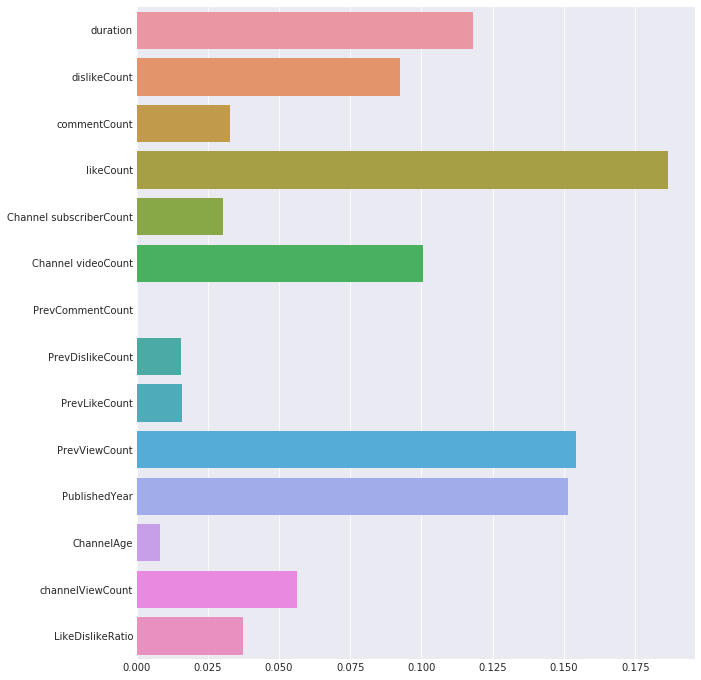

In [76]:
X = X.drop('vid', axis = 1)
sns.set_style('darkgrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

### Modeling on validation set

In [91]:
df = feature_engineer(dfValidationSet)

In [9]:
dfData = pd.read_csv('/home/archit/Desktop/ad vs organic/final_combined_lang_organic_duration3.csv')

In [12]:
dfData['cleanDescriptions'][0]

'darshanraval subscribe press bell icon videos like facebook follow twitter follow instagram share subscribe comment jamming darshan raval radiomirchi baarish darshan raval darshanraval baarish tera zikr pehli mohabatt raw star live concert raipur radio mirchi jamming darshan raval radiomirchi baarish acousticrishabh'